# Coin search by t-SNE via Tensorflow
- https://github.com/despoisj/CoinsDataset
- https://github.com/kylemcdonald/Parametric-t-SNE
- https://github.com/gokceneraslan/tensorsne
- https://github.com/zaburo-ch/Parametric-t-SNE-in-Keras/blob/master/mlp_param_tsne.py
- https://github.com/danielfrg/tsne

### todo:
- make global batch NxN instead of b x n x n for pairwise probabilitis
- look up to global probs whe training on small images batchs
- augment coins dataset: rotate, add noise and change lightness and contrast
- must ignore darkness/lights and rotates while search
- train on rgb coins
- test on real data
- auto prepare input data -- remove noise, rotate etc
    

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tensorflow.examples.tutorials.mnist import input_data
from IPython.display import clear_output
import pandas as pd
from scipy import spatial
from collections import defaultdict
import os
import cv2
import itertools

%run ../common/datasets.ipynb
%run ../common/visualisation.ipynb
%run ../common/tsne.ipynb

%matplotlib inline

## Load data

In [3]:
def load_stamps_dataset(ndata):
    return load_image_dataset(
        img_shape = [64, 64, 1],
        path      = "/netforge/datasets/common/document_parts/10000/stamp",
        ndata     = ndata)

def load_coins_dataset(ndata):
    return load_image_dataset(
        img_shape = [64, 64, 1],
        path      = "/netforge/datasets/private/roman/coins/rotated",
        ndata     = ndata)

In [5]:
data_size = 1000
(
    image_shape, 
    file_num,
    train_images, 
    train_labels, 
    test_images, 
    test_labels
) = load_coins_dataset(data_size)

print("File num   :", file_num)
print("Data size  :", data_size)
print("Train shape:", list(train_images.shape))
print("Test  shape:", list(test_images.shape))
print("Image shape:", image_shape)

File num   : 2000
Data size  : 1000
Train shape: [1000, 4096]
Test  shape: [1000, 4096]
Image shape: [64, 64, 1]


## Visualisation

Train images:


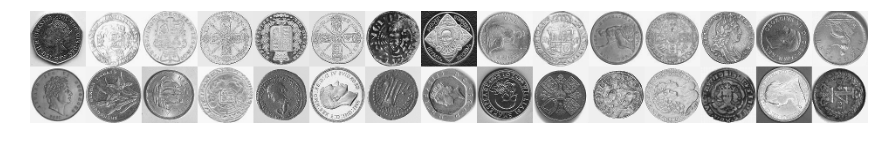

Test images:


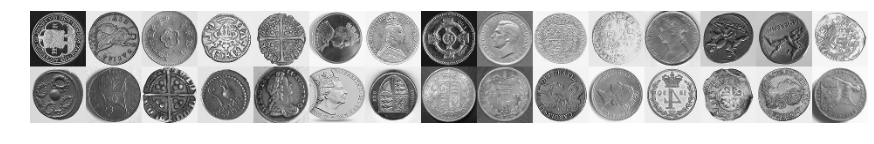

In [6]:
print("Train images:")
show_images(train_images, image_shape, rows=2, cols=15)
print("Test images:")
show_images(test_images, image_shape, rows=2, cols=15)

## Prepare TSNE data

In [5]:
%%time

joint_probs = compute_joint_probabilities(
    samples    = train_images, 
    batch_size = data_size // 10)

compute_joint_probabilities
  batch 0 ... 
  batch 1 ... 
  batch 2 ... 
  batch 3 ... 
  batch 4 ... 
  batch 5 ... 
  batch 6 ... 
  batch 7 ... 
  batch 8 ... 
  batch 9 ... 
CPU times: user 35.7 s, sys: 6.98 s, total: 42.7 s
Wall time: 28.9 s


## TF Neural Networks

In [6]:
def conv2d_maxpool(inputs, filters, kernel_size=[3,3], padding="same", activation=tf.nn.relu):
    l = tf.layers.conv2d(
        inputs=inputs,
        filters=filters,
        kernel_size=kernel_size,
        padding=padding,
        activation=tf.nn.relu)
    return tf.layers.max_pooling2d(l, pool_size=[2, 2], strides=2)

def Perceptron(inputs, out_dim):
    l = inputs
    l = tf.contrib.layers.flatten(l)
    l = tf.layers.dense(l, units=100, activation=tf.nn.relu)
    l = tf.layers.dense(l, units=200, activation=tf.nn.relu)
    l = tf.layers.dense(l, units=100, activation=tf.nn.relu)
    l = tf.layers.dense(l, units=out_dim)
    return l

def ConvNet(inputs, out_dim):
    l = inputs
    l = conv2d_maxpool(l, 16)
    l = conv2d_maxpool(l, 32)
    l = conv2d_maxpool(l, 64)
    l = conv2d_maxpool(l, 128)
    l = tf.contrib.layers.flatten(l)
    l = tf.layers.dense(l, units=300, activation=tf.nn.relu)
    l = tf.layers.dense(l, units=out_dim)
    return l

### Embedding Graph

In [43]:
learning_rate = 1e-4
embed_dims    = 30
batch_size    = data_size // joint_probs.shape[0]

tf.reset_default_graph()
em_graph = tf.Graph()
with em_graph.as_default():
    with tf.name_scope('embedding'):
        with tf.device('/gpu:0'):
            images_pl  = tf.placeholder(dtype=tf.float32, shape=[None,]+image_shape)
            probs_pl   = tf.placeholder(dtype=tf.float32, shape=joint_probs.shape[-2:])
            embed_op   = ConvNet(images_pl, embed_dims)    
            embed_loss = tsne_loss(probs_pl, batch_size, embed_dims, embed_op)
            train_op   = tf.train.AdamOptimizer(learning_rate).minimize(embed_loss)
            init_op    = tf.global_variables_initializer()
print("joint_probs.shape:", list(joint_probs.shape))

joint_probs.shape: [10, 1200, 1200]


### Train embedding

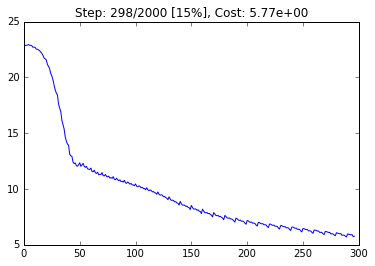

CPU times: user 44.8 s, sys: 12.5 s, total: 57.3 s
Wall time: 55.2 s


In [44]:
%%time

try:
    sess.close()
except:
    pass

sess = tf.Session(graph=em_graph)
sess.run(init_op)

def plot_costs(costs, step, step_num):
    plt.plot(costs)
    plt.title("Step: %d/%d [%.0f%%], Cost: %.2e" % (
        step+1, step_num, 100*(step+1)/step_num, costs[-1]))
    clear_output(True)
    plt.show()

def get_next_batch(i, bs):
    imgs = train_images[i:i+bs]
    imgs = np.reshape(imgs, [-1,]+image_shape)
    lbls = train_labels[i:i+bs]
    i = (i + bs) % (len(train_images))
    return i, imgs, lbls

def do_train(step_num, log_every=10):
    try:
        costs = []
        i = 0
        for step in range(step_num):
            pi = i//batch_size
            i, images, _ = get_next_batch(i, batch_size)
            _, cost = sess.run([train_op, embed_loss], feed_dict={
                images_pl: images,
                probs_pl : joint_probs[pi]
            })
            costs.append(cost)
            if step % log_every == log_every-1:
                plot_costs(costs, step, step_num)
    except KeyboardInterrupt:
        pass
    plot_costs(costs, step, step_num)
    
do_train(2000, 10)

### Find nearest

embed_database ...
embed_targets ...
find_nearest ...
Data size: 12000 x 30


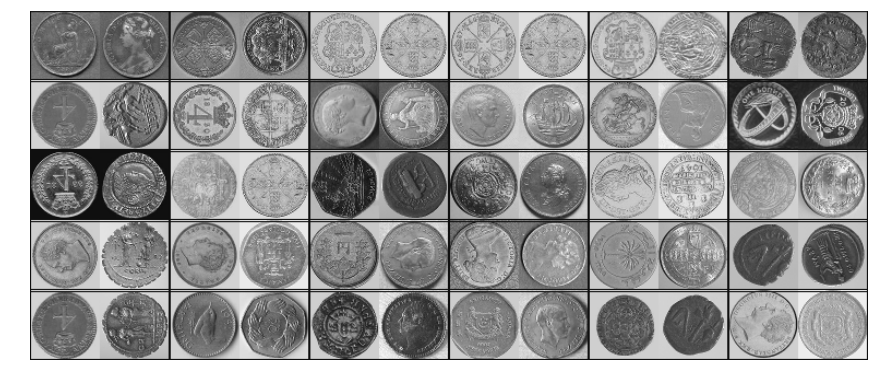

CPU times: user 2.72 s, sys: 288 ms, total: 3.01 s
Wall time: 3.08 s


In [47]:
%%time

def embed_database(imgs):
    print("embed_database ...")
    imgs = np.reshape(imgs, [-1,]+image_shape)
    embeds = np.zeros(shape=[data_size, embed_dims])
    bs = batch_size
    for i in range(data_size//batch_size):
        batch = imgs[i*bs:(i+1)*bs,:]
        embeds[i*bs:(i+1)*bs,:] = sess.run(embed_op, feed_dict = {images_pl : batch})
    return imgs, embeds

def embed_targets(ds, num):
    print("embed_targets ...")
    idx = list(range(len(ds)))
    np.random.shuffle(idx)
    imgs = ds[idx][:num]
    
    imgs = np.reshape(imgs, [-1,]+image_shape)
    embeds = sess.run(embed_op, feed_dict = {images_pl : imgs})
    return imgs, embeds

def find_nearest(targets, candidates):
    print("find_nearest ...")
    tree = spatial.KDTree(candidates)
    results = tree.query(targets)
    return results[1], results[0] 

def test_find_nearest_images(database, targets, num):
    dat_img, dat_emb = embed_database(database)
    trg_img, trg_emb = embed_targets(targets, num)

    nearests, distances = find_nearest(trg_emb, dat_emb)
    res_img = dat_img[nearests]

    print("Data size:", data_size, "x", embed_dims)
    
    h = image_shape[0]
    w = image_shape[1]
    img1 = trg_img.reshape([num*h,w])
    img2 = res_img.reshape([num*h,w])
    img1[:,0]   = 0
    img2[:,w-1] = 0
    sheet = np.concatenate([img1, img2], axis=1)
    sheet[np.arange(0,h*num,h)-1,:] = 0
    sheet[np.arange(0,h*num,h)+1,:] = 0
    cols = 6
    show_images(images=sheet, image_shape=[h, 2*w], cols=cols, rows=num//cols)
        
test_find_nearest_images(
    database  = test_images, 
    targets   = train_images*.85, 
    num=32)

### EOF